# ReLU vs SELU networks on the Cifar-10 data set

Adapted from SNNs bioinf-jku [SNNs bioinf-jku](https://github.com/bioinf-jku/SNNs)

## Fetch Dataset

In [1]:
import os
import pickle
import sys
import tarfile
import zipfile
from urllib.request import urlretrieve

import time

import numpy as np


def get_data_set(name="train", cifar=10):
    x = None
    y = None
    l = None
    
    maybe_download_and_extract()
    
    folder_name = "cifar_10" if cifar == 10 else "cifar_100"
    
    f = open('./data_set/' + folder_name + '/batches.meta', 'rb')
    datadict = pickle.load(f, encoding='latin1')
    f.close()
    l = datadict['label_names']
    
    # mean and sdev of training set
#     mean_train = 0.4733630004850902
#     sdev_train = 0.2515689250632212
    
    if name is "train":
        for i in range(5):
            f = open('./data_set/' + folder_name + '/data_batch_' + str(i + 1), 'rb')
            datadict = pickle.load(f, encoding='latin1')
            f.close()
            
            _X = datadict["data"]
            _Y = datadict['labels']
            
            _X = np.array(_X, dtype=float) / 255.0
            _X = _X.reshape([-1, 3, 32, 32])
            _X = _X.transpose([0, 2, 3, 1])
            _X = _X.reshape(-1, 32 * 32 * 3)
            
            if x is None:
                x = _X
                y = _Y
            else:
                x = np.concatenate((x, _X), axis=0)
                y = np.concatenate((y, _Y), axis=0)
        
        # Normalize Data to mean = 0, stdev = 1
        x_mean_train = x.mean()
        x_sdev_train = x.std()
        x_var_train = x.var()
        x = (x - x_mean_train) / x_sdev_train
    
    elif name is "test":
        f = open('./data_set/' + folder_name + '/test_batch', 'rb')
        datadict = pickle.load(f, encoding='latin1')
        f.close()
        
        x = datadict["data"]
        y = np.array(datadict['labels'])
        
        x = np.array(x, dtype=float) / 255.0
        x = x.reshape([-1, 3, 32, 32])
        x = x.transpose([0, 2, 3, 1])
        x = x.reshape(-1, 32 * 32 * 3)
        
        # Normalize Data according to mean and sdev of training set
        x_mean_test = x.mean()
        x_sdev_test = x.std()
        x_var_test = x.var()
        x = (x - x_mean_test) / x_sdev_test
    
    def dense_to_one_hot(labels_dense, num_classes=10):
        num_labels = labels_dense.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
        
        return labels_one_hot
    
    return x, dense_to_one_hot(y), l


def _print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()


def maybe_download_and_extract():
    main_directory = "./data_set/"
    cifar_10_directory = main_directory + "cifar_10/"
    cifar_100_directory = main_directory + "cifar_100/"
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)
        
        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_10 = file_path
        file_path, _ = urlretrieve(url=url, filename=file_path, reporthook=_print_download_progress)
        
        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")
        
        url = "http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_100 = file_path
        file_path, _ = urlretrieve(url=url, filename=file_path, reporthook=_print_download_progress)
        
        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")
        
        os.rename(main_directory + "./cifar-10-batches-py", cifar_10_directory)
        os.rename(main_directory + "./cifar-100-python", cifar_100_directory)
        os.remove(zip_cifar_10)
        os.remove(zip_cifar_100)

## Scaled ELU

In [2]:
import tensorflow as tf
from tensorflow.python.framework import ops


def selu(x, name="selu"):
    """ When using SELUs you have to keep the following in mind:
    # (1) scale inputs to zero mean and unit variance
    # (2) use SELUs
    # (3) initialize weights with stddev sqrt(1/n)
    # (4) use SELU dropout
    """
    with ops.name_scope(name) as scope:
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale * tf.where(x >= 0.0, x, alpha * tf.nn.elu(x))

## Some helpers to build the network

In [3]:
from math import sqrt
import numpy as np
import tensorflow as tf


def _variable_with_weight_decay(name, shape, activation, stddev, wd=None):    
    # Determine number of input features from shape
    f_in = np.prod(shape[:-1]) if len(shape) == 4 else shape[0]
    # Determine number of ouput features from shape
    f_out = shape[-1] #if len(shape) == 4 else shape[0]
    
    #Calculate sdev for initialization according to activation function
    if activation == selu:
#         sdev = sqrt(1 / f_in)
#         sdev = sqrt(2 / f_in)# He Initialization
        sdev = sqrt(2 / (f_in+f_out)) #Xavier Initialization
    elif activation == tf.nn.relu:
#         sdev = sqrt(1 / f_in)
#         sdev = sqrt(2 / f_in)# He Initialization
        sdev = sqrt(2 / (f_in+f_out)) #Xavier Initialization
    elif activation == tf.nn.elu:
        sdev = sqrt(1.5505188080679277 / f_in)
    else:
        sdev = stddev
    
    var = tf.get_variable(name=name, shape=shape,
                          initializer=tf.truncated_normal_initializer(stddev=sdev, dtype=tf.float32))
#     var = tf.get_variable(name=name, shape=shape,
#                           initializer=tf.variance_scaling_initializer(factor=1.0, mode='FAN_AVG', uniform=False,
#                                  seed=None, dtype=tf.float32)) # Xavier Initialization
    
#     var = tf.get_variable(name=name, shape=shape,
#                           initializer=tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_AVG', 
#                                 uniform=False, seed=None, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var

In [4]:
import tensorflow as tf


def conv2d(scope_name, input, activation, ksize, f_in, f_out, bias_init=0.0, stddev=5e-2):
    with tf.variable_scope(scope_name) as scope:
        kernel = _variable_with_weight_decay('weights', shape=[ksize, ksize, f_in, f_out], activation=activation,
                                             stddev=stddev)
        conv = tf.nn.conv2d(input, kernel, [1, 1, 1, 1], padding='SAME')
        biases = tf.get_variable('biases', [f_out], initializer=tf.constant_initializer(bias_init), dtype=tf.float32)
        pre_activation = tf.nn.bias_add(conv, biases)
        return activation(pre_activation, name=scope.name)


def fc(scope_name, input, activation, n_in, n_out, stddev=0.04, bias_init=0.0, weight_decay=None):
    with tf.variable_scope(scope_name) as scope:
        weights = _variable_with_weight_decay('weights', shape=[n_in, n_out], activation=activation, stddev=stddev,
                                              wd=weight_decay)
        biases = tf.get_variable(name='biases', shape=[n_out], initializer=tf.constant_initializer(bias_init),
                                 dtype=tf.float32)
        return activation(tf.matmul(input, weights) + biases, name=scope.name)

## Build the model with a specified activation function

In [5]:
def model(activation):
    _IMAGE_SIZE = 32
    _IMAGE_CHANNELS = 3
    _NUM_CLASSES = 10
    _RESHAPE_SIZE = 4 * 4 * 128
    
    # set activation function
    act = selu if activation == "selu" else tf.nn.elu if activation == "elu" else tf.nn.relu
    
    with tf.variable_scope(activation):
        # input
        with tf.name_scope('data'):
            x = tf.placeholder(tf.float32, shape=[None, _IMAGE_SIZE * _IMAGE_SIZE * _IMAGE_CHANNELS], name='Input')
            y = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='Output')
            x_image = tf.reshape(x, [-1, _IMAGE_SIZE, _IMAGE_SIZE, _IMAGE_CHANNELS], name='images')
        
        # Conv 1
        conv1 = conv2d("conv1", input=x_image, activation=act, ksize=5, f_in=3, f_out=64)
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool1')
        
        # Conv 2
        conv2 = conv2d("conv2", input=pool1, activation=act, ksize=5, f_in=64, f_out=64, bias_init=0.1)
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool2')
        
        # Conv 3-5
        conv3 = conv2d("conv3", input=pool2, activation=act, ksize=3, f_in=64, f_out=128)
        conv4 = conv2d("conv4", input=conv3, activation=act, ksize=3, f_in=128, f_out=128)
        conv5 = conv2d("conv5", input=conv4, activation=act, ksize=3, f_in=128, f_out=128)
        
        # Pool
        pool3 = tf.nn.max_pool(conv5, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME', name='pool3')
        
        # Reshape
        reshape = tf.reshape(pool3, [-1, _RESHAPE_SIZE])
        dim = reshape.get_shape()[1].value
        
        # Fully Connected
        fc1 = fc('fully_connected1', input=reshape, activation=act, n_in=dim, n_out=384, stddev=0.04, bias_init=0.1,
                 weight_decay=0.004)
        fc2 = fc('fully_connected2', input=fc1, activation=act, n_in=384, n_out=192, stddev=0.04, bias_init=0.1,
                 weight_decay=0.004)
        
        # Fully Connected Dropout
#         fc1 = fc('fully_connected1', input=reshape, activation=act, n_in=dim, n_out=384, stddev=0.04, bias_init=0.1)
        
#         keep_prob = tf.placeholder(tf.float32)
#         fc1_drop = tf.nn.dropout(fc1, keep_prob)
    
#         fc2 = fc('fully_connected2', input=fc1_drop, activation=act, n_in=384, n_out=192, stddev=0.04, bias_init=0.1)
#         fc2_drop = tf.nn.dropout(fc2, keep_prob)
        
        # Softmax
        with tf.variable_scope('output') as scope:
            weights = _variable_with_weight_decay('weights', [192, _NUM_CLASSES], stddev=1 / 192.0,
                                                  activation=activation,
                                                  wd=0.0)
#             weights = _variable_with_weight_decay('weights', [192, _NUM_CLASSES], stddev=1 / 192.0,
#                                                   activation=activation)
            biases = tf.get_variable(name='biases', shape=[_NUM_CLASSES], initializer=tf.constant_initializer(0.0),
                                     dtype=tf.float32)
            softmax_linear = tf.add(tf.matmul(fc2, weights), biases, name=scope.name)
            
            # output
            y_pred_cls = tf.argmax(softmax_linear, dimension=1)
        
        # Define Loss and Optimizer
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=softmax_linear, labels=y))
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)
#         optimizer = tf.train.MomentumOptimizer(learning_rate=1e-4, momentum=0.9).minimize(loss)
        
        correct_prediction = tf.equal(y_pred_cls, tf.argmax(y, dimension=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return {"x": x, "y": y, "output": y_pred_cls, "loss": loss, "accuracy": accuracy, "optimizer": optimizer, 
            "name": activation}
#         return {"x": x, "y": y, "output": y_pred_cls, "loss": loss, "accuracy": accuracy, "optimizer": optimizer, 
#             "name": activation, "keep_prob": keep_prob}

## Evaluate on Test Set

In [6]:
def predict_test(test_x, test_y, models):
    """
        Make prediction for all images in test_x
    """
    i = 0
    predicted_class = {"selu": np.zeros(shape=len(test_x), dtype=np.int), 
                       #"elu": np.zeros(shape=len(test_x), dtype=np.int), 
                       "relu":np.zeros(shape=len(test_x), dtype=np.int)}
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        for name, model in models.items():
            predicted_class[name][i:j] = sess.run(model["output"], feed_dict={
#                 model['x']: batch_xs, model['y']: batch_ys, model['keep_prob']: 1.0})
                model['x']: batch_xs, model['y']: batch_ys})
        i = j
    
    accuracy = {"selu": 0, "relu": 0}
    for name, model in models.items():
        correct = (np.argmax(test_y, axis=1) == predicted_class[name])        
        accuracy[name] = correct.mean() * 100        
    
    print("Accuracy on Test-Set (SELU/RELU): {0:.2f}% | {1:.2f}% |".format(
        accuracy["selu"], accuracy["relu"]))
    
    return accuracy


## Plotting

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metric(title, ylabel, metric):
    # Training Accuracy
    plt.figure()    
    plt.title(title, size="xx-large")
    plt.ylabel(ylabel, size="x-large")
#     plt.xlabel("epoch", size="x-large") 
    plt.tick_params(axis="x", bottom="off", labelbottom="off")
    
    # select manually for consistent colors
    plt.plot(metric["selu"], label="SELU", linewidth=2)
    #plt.plot(metric["elu"], label="ELU", linewidth=2)
    plt.plot(metric["relu"], label="RELU", linewidth=2)
        
    plt.legend()
    plt.show()

def plot(train_loss, train_accuracy, test_accuracy):    
    # Training Loss
    plot_metric("Training Loss", "Loss", train_loss)
    
    # Training Accuracy
    plot_metric("Training Accuracy", "Accuracy", train_accuracy)
    
    # Test Accuracy
    plot_metric("Test Accuracy", "Accuracy", test_accuracy)

## Training

In [8]:
merged_summary_op = tf.summary.merge_all()
def train(session, num_epoch, train_x, train_y, test_x, test_y, models):
    """
        Train CNN
    """    
    train_loss = {"selu": [], "relu": []}
    train_accuracy = {"selu": [], "relu": []}    
    test_accuracy = {"selu": [], "relu": []}
    
    # start training
    print(time.localtime())
    for epoch in range(num_epoch):
        total_batch = int(train_x.shape[0]/_BATCH_SIZE)
        print("Epoch: ", epoch)
        # Loop over all batches
        for i in range(total_batch):
            randidx = np.random.randint(len(train_x), size=_BATCH_SIZE)
            batch_xs = train_x[randidx]
            batch_ys = train_y[randidx]

            optimizers = []
            feed_dict = {}
            for name, model in models.items():
                optimizers.append(model["optimizer"])
#                 feed_dict.update({model["x"]: batch_xs, model["y"]: batch_ys, model["keep_prob"]: 0.5})
                feed_dict.update({model["x"]: batch_xs, model["y"]: batch_ys})

            # train
            session.run( optimizers, feed_dict=feed_dict)
            

            # print training loss
            if (i % 10 == 0) :
                l_selu, l_relu, acc_selu, acc_relu = session.run(
                    [models['selu']['loss'],  models['relu']['loss'], 
                     models['selu']['accuracy'], models['relu']['accuracy']],
                    feed_dict=feed_dict)

                msg = "Minibatch: {0:>6}, " \
                      "accuracy (SELU/RELU): {1:>6.1%} | {2:>6.1%} |, " \
                      "loss (SELU/RELU): {3:.2f} | {4:.2f} |"
                print(msg.format(i, acc_selu, acc_relu, l_selu, l_relu))            

                # collect metrics for plots                            
                train_loss["selu"].append(l_selu)
#                 train_loss["elu"].append(l_elu)
                train_loss["relu"].append(l_relu)
                train_accuracy["selu"].append(acc_selu)
#                 train_accuracy["elu"].append(acc_elu)
                train_accuracy["relu"].append(acc_relu)

        # evaluate test set accuracy
        acc = predict_test(test_x, test_y, models)                
        test_accuracy["selu"].append(acc["selu"])
#         test_accuracy["elu"].append(acc["elu"])
        test_accuracy["relu"].append(acc["relu"])
#         saver.save(session, save_path=_SAVE_PATH + "/checkpoint", global_step=epoch)
        print("Saved checkpoint.")
        
    print(time.localtime())
    return train_loss, train_accuracy, test_accuracy

## Parameters

In [9]:
_IMG_SIZE = 32
_NUM_CHANNELS = 3
# _BATCH_SIZE = 128
_BATCH_SIZE = 500
_CLASS_SIZE = 10
# _ITERATION = 10000
_EPOCH = 50
_SAVE_PATH = "./checkpoints/cifar-10-he"

# Tensorboard
# logs_path = './tensorboard/model1'
# merged_summary_op = tf.summary.merge_all()

In [10]:
import os

# Set GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

if not os.path.exists(_SAVE_PATH):
    os.makedirs(_SAVE_PATH)

## Create Models

In [11]:
import tensorflow as tf

# Build Graph
relu = model("relu")
selu = model("selu")
#elu = model("elu")

Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use the `axis` argument instead


## Run Training

In [12]:
#from time import time

import tensorflow as tf

# Some Tensorflow configuration
tf_config = tf.ConfigProto(log_device_placement=True)
tf_config.gpu_options.allow_growth = True

# Initialize Dataset
train_x, train_y, train_l = get_data_set("train", cifar=10)
test_x, test_y, test_l = get_data_set("test", cifar=10)

saver = tf.train.Saver()
with tf.Session(config=tf_config) as sess:
    try:
        print("Trying to restore last checkpoint ...")
        last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=_SAVE_PATH)
        saver.restore(sess, save_path=last_chk_path)
        print("Restored checkpoint from:", last_chk_path)
    except:
        print("Failed to restore checkpoint. Initializing variables instead.")
        sess.run(tf.global_variables_initializer())
    
    if _EPOCH != 0:
        train_loss, train_accuracy, test_accuracy = train(
            sess, _EPOCH, train_x, train_y, test_x, test_y, 
            models={"relu": relu, "selu": selu})

Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.
time.struct_time(tm_year=2017, tm_mon=10, tm_mday=1, tm_hour=13, tm_min=54, tm_sec=8, tm_wday=6, tm_yday=274, tm_isdst=0)
Epoch:  0
Minibatch:      0, accuracy (SELU/RELU):  16.2% |  11.8% |, loss (SELU/RELU): 2.27 | 2.30 |
Minibatch:     10, accuracy (SELU/RELU):  24.0% |  17.6% |, loss (SELU/RELU): 2.05 | 2.27 |
Minibatch:     20, accuracy (SELU/RELU):  31.2% |  22.6% |, loss (SELU/RELU): 1.94 | 2.13 |
Minibatch:     30, accuracy (SELU/RELU):  33.8% |  30.6% |, loss (SELU/RELU): 1.82 | 1.95 |
Minibatch:     40, accuracy (SELU/RELU):  45.0% |  33.4% |, loss (SELU/RELU): 1.65 | 1.83 |
Minibatch:     50, accuracy (SELU/RELU):  42.6% |  32.2% |, loss (SELU/RELU): 1.64 | 1.86 |
Minibatch:     60, accuracy (SELU/RELU):  43.2% |  33.4% |, loss (SELU/RELU): 1.59 | 1.84 |
Minibatch:     70, accuracy (SELU/RELU):  45.4% |  37.6% |, loss (SELU/RELU): 1.47 | 1.72 |
Minibatch:     80, accuracy (SEL

Minibatch:     10, accuracy (SELU/RELU):  72.6% |  60.6% |, loss (SELU/RELU): 0.81 | 1.10 |
Minibatch:     20, accuracy (SELU/RELU):  72.0% |  63.6% |, loss (SELU/RELU): 0.76 | 1.05 |
Minibatch:     30, accuracy (SELU/RELU):  69.8% |  57.8% |, loss (SELU/RELU): 0.87 | 1.20 |
Minibatch:     40, accuracy (SELU/RELU):  73.4% |  62.2% |, loss (SELU/RELU): 0.77 | 1.08 |
Minibatch:     50, accuracy (SELU/RELU):  68.4% |  61.2% |, loss (SELU/RELU): 0.81 | 1.09 |
Minibatch:     60, accuracy (SELU/RELU):  72.8% |  64.2% |, loss (SELU/RELU): 0.78 | 1.12 |
Minibatch:     70, accuracy (SELU/RELU):  73.6% |  60.2% |, loss (SELU/RELU): 0.79 | 1.11 |
Minibatch:     80, accuracy (SELU/RELU):  72.2% |  64.2% |, loss (SELU/RELU): 0.73 | 1.04 |
Minibatch:     90, accuracy (SELU/RELU):  74.6% |  62.4% |, loss (SELU/RELU): 0.76 | 1.07 |
Accuracy on Test-Set (SELU/RELU): 67.98% | 61.16% |
Saved checkpoint.
Epoch:  9
Minibatch:      0, accuracy (SELU/RELU):  76.8% |  66.6% |, loss (SELU/RELU): 0.69 | 0.98 |


Minibatch:     40, accuracy (SELU/RELU):  84.2% |  68.2% |, loss (SELU/RELU): 0.48 | 0.90 |
Minibatch:     50, accuracy (SELU/RELU):  82.2% |  68.6% |, loss (SELU/RELU): 0.52 | 0.89 |
Minibatch:     60, accuracy (SELU/RELU):  83.4% |  70.8% |, loss (SELU/RELU): 0.46 | 0.82 |
Minibatch:     70, accuracy (SELU/RELU):  82.4% |  66.8% |, loss (SELU/RELU): 0.54 | 0.92 |
Minibatch:     80, accuracy (SELU/RELU):  83.2% |  69.0% |, loss (SELU/RELU): 0.52 | 0.87 |
Minibatch:     90, accuracy (SELU/RELU):  82.0% |  71.0% |, loss (SELU/RELU): 0.52 | 0.89 |
Accuracy on Test-Set (SELU/RELU): 72.73% | 65.98% |
Saved checkpoint.
Epoch:  17
Minibatch:      0, accuracy (SELU/RELU):  81.0% |  69.8% |, loss (SELU/RELU): 0.53 | 0.89 |
Minibatch:     10, accuracy (SELU/RELU):  79.8% |  69.0% |, loss (SELU/RELU): 0.54 | 0.86 |
Minibatch:     20, accuracy (SELU/RELU):  81.4% |  71.2% |, loss (SELU/RELU): 0.52 | 0.81 |
Minibatch:     30, accuracy (SELU/RELU):  81.0% |  68.6% |, loss (SELU/RELU): 0.52 | 0.89 |

Minibatch:     70, accuracy (SELU/RELU):  89.6% |  74.2% |, loss (SELU/RELU): 0.30 | 0.68 |
Minibatch:     80, accuracy (SELU/RELU):  90.8% |  76.0% |, loss (SELU/RELU): 0.29 | 0.68 |
Minibatch:     90, accuracy (SELU/RELU):  91.6% |  74.0% |, loss (SELU/RELU): 0.28 | 0.78 |
Accuracy on Test-Set (SELU/RELU): 73.93% | 69.78% |
Saved checkpoint.
Epoch:  25
Minibatch:      0, accuracy (SELU/RELU):  90.8% |  74.2% |, loss (SELU/RELU): 0.28 | 0.69 |
Minibatch:     10, accuracy (SELU/RELU):  91.8% |  76.6% |, loss (SELU/RELU): 0.27 | 0.69 |
Minibatch:     20, accuracy (SELU/RELU):  91.0% |  76.4% |, loss (SELU/RELU): 0.29 | 0.70 |
Minibatch:     30, accuracy (SELU/RELU):  93.0% |  75.8% |, loss (SELU/RELU): 0.26 | 0.69 |
Minibatch:     40, accuracy (SELU/RELU):  93.2% |  76.6% |, loss (SELU/RELU): 0.30 | 0.73 |
Minibatch:     50, accuracy (SELU/RELU):  89.2% |  71.8% |, loss (SELU/RELU): 0.33 | 0.79 |
Minibatch:     60, accuracy (SELU/RELU):  90.8% |  73.6% |, loss (SELU/RELU): 0.30 | 0.75 |

Accuracy on Test-Set (SELU/RELU): 74.31% | 72.46% |
Saved checkpoint.
Epoch:  33
Minibatch:      0, accuracy (SELU/RELU):  94.6% |  78.4% |, loss (SELU/RELU): 0.16 | 0.61 |
Minibatch:     10, accuracy (SELU/RELU):  97.4% |  78.4% |, loss (SELU/RELU): 0.14 | 0.62 |
Minibatch:     20, accuracy (SELU/RELU):  96.4% |  80.0% |, loss (SELU/RELU): 0.14 | 0.59 |
Minibatch:     30, accuracy (SELU/RELU):  95.6% |  79.4% |, loss (SELU/RELU): 0.14 | 0.60 |
Minibatch:     40, accuracy (SELU/RELU):  96.6% |  79.2% |, loss (SELU/RELU): 0.15 | 0.60 |
Minibatch:     50, accuracy (SELU/RELU):  95.2% |  76.6% |, loss (SELU/RELU): 0.16 | 0.62 |
Minibatch:     60, accuracy (SELU/RELU):  96.2% |  76.6% |, loss (SELU/RELU): 0.14 | 0.62 |
Minibatch:     70, accuracy (SELU/RELU):  96.0% |  77.4% |, loss (SELU/RELU): 0.14 | 0.61 |
Minibatch:     80, accuracy (SELU/RELU):  96.8% |  78.2% |, loss (SELU/RELU): 0.12 | 0.58 |
Minibatch:     90, accuracy (SELU/RELU):  97.2% |  80.0% |, loss (SELU/RELU): 0.13 | 0.65 |

Minibatch:     20, accuracy (SELU/RELU):  99.8% |  83.8% |, loss (SELU/RELU): 0.05 | 0.48 |
Minibatch:     30, accuracy (SELU/RELU):  99.4% |  82.8% |, loss (SELU/RELU): 0.05 | 0.47 |
Minibatch:     40, accuracy (SELU/RELU):  99.0% |  85.2% |, loss (SELU/RELU): 0.05 | 0.47 |
Minibatch:     50, accuracy (SELU/RELU):  99.0% |  85.2% |, loss (SELU/RELU): 0.05 | 0.50 |
Minibatch:     60, accuracy (SELU/RELU):  99.2% |  82.4% |, loss (SELU/RELU): 0.04 | 0.50 |
Minibatch:     70, accuracy (SELU/RELU):  99.6% |  85.0% |, loss (SELU/RELU): 0.04 | 0.48 |
Minibatch:     80, accuracy (SELU/RELU):  99.4% |  82.8% |, loss (SELU/RELU): 0.04 | 0.51 |
Minibatch:     90, accuracy (SELU/RELU):  99.8% |  83.4% |, loss (SELU/RELU): 0.04 | 0.51 |
Accuracy on Test-Set (SELU/RELU): 73.96% | 73.37% |
Saved checkpoint.
Epoch:  42
Minibatch:      0, accuracy (SELU/RELU):  98.4% |  83.4% |, loss (SELU/RELU): 0.05 | 0.47 |
Minibatch:     10, accuracy (SELU/RELU):  99.6% |  85.0% |, loss (SELU/RELU): 0.05 | 0.48 |

Minibatch:     50, accuracy (SELU/RELU): 100.0% |  87.6% |, loss (SELU/RELU): 0.01 | 0.37 |
Minibatch:     60, accuracy (SELU/RELU): 100.0% |  85.8% |, loss (SELU/RELU): 0.02 | 0.45 |
Minibatch:     70, accuracy (SELU/RELU): 100.0% |  89.2% |, loss (SELU/RELU): 0.02 | 0.37 |
Minibatch:     80, accuracy (SELU/RELU): 100.0% |  86.2% |, loss (SELU/RELU): 0.02 | 0.41 |
Minibatch:     90, accuracy (SELU/RELU): 100.0% |  83.2% |, loss (SELU/RELU): 0.01 | 0.43 |
Accuracy on Test-Set (SELU/RELU): 74.64% | 73.61% |
Saved checkpoint.
time.struct_time(tm_year=2017, tm_mon=10, tm_mday=1, tm_hour=14, tm_min=4, tm_sec=34, tm_wday=6, tm_yday=274, tm_isdst=0)


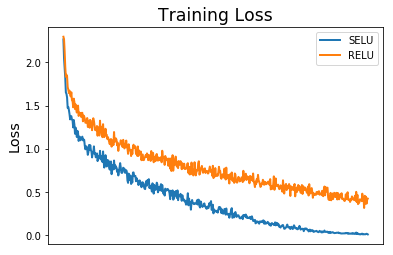

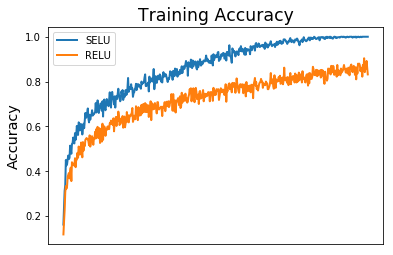

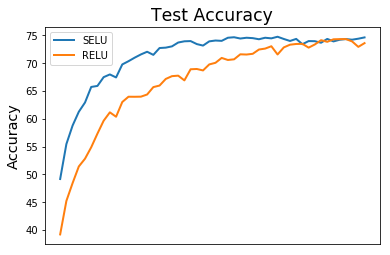

In [13]:
# Plot Training Loss, Training Accuracy and Test Accuracy for the three activation functions
plot(train_loss, train_accuracy, test_accuracy)        